<a href="https://colab.research.google.com/github/srimanthtenneti/Autoencoders/blob/main/Convolutional_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as f

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [126]:
data_trasnform = transforms.ToTensor()

In [127]:
dataset = torchvision.datasets.MNIST('./root' , transform = data_trasnform , download = True , train = True)
testset = torchvision.datasets.MNIST('./root' , transform = data_trasnform , download = True , train = False)

In [128]:
batchsize   = 25
num_workers = 0 

In [129]:
trainloader = DataLoader(dataset , shuffle = True , batch_size = batchsize , num_workers = num_workers)
testloader  = DataLoader(testset , shuffle = True , batch_size = batchsize , num_workers = num_workers)

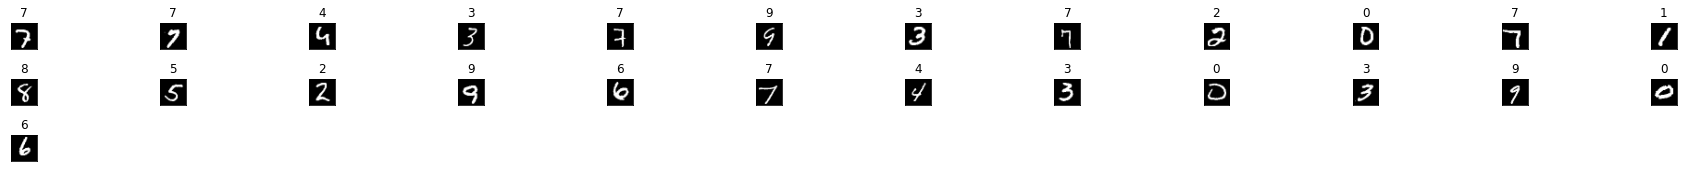

In [130]:
images , labels = iter(trainloader).next()
images = images.numpy()
fig = plt.figure(figsize = (25,4))

for i in range(batchsize):
  ax = fig.add_subplot(5 , batchsize / 2 , i + 1 , xticks = [] , yticks = [])
  ax.imshow(np.squeeze(images[i]) , cmap = 'gray')
  ax.set_title(labels[i].item())

plt.tight_layout()


In [131]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(64, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder().cuda()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [132]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [133]:
def train(n_epochs , model):
  training_loss = []

  for epoch in range(n_epochs):
    trainloss = 0.0
    for batch_i , (images , labels) in enumerate(trainloader):
      optimizer.zero_grad()
      output = model(images.cuda())
      loss = criterion(output , images.cuda()) # Here we comapre with the image itself insted of the label
      loss.backward()
      optimizer.step()
      trainloss += loss.item()  
    print("Epoch: {} , Batch: {} , Training Loss: {}".format(epoch + 1 , batch_i + 1 , trainloss / len(trainloader)))
    training_loss.append(trainloss)
        
  print("Training Completed !!!")

In [134]:
def plot_images(model):

  images , labels = iter(testloader).next()
  preds = model(images.cuda()).view(-1, 28 , 28).cpu()
  images = images.numpy()

  fig1 = plt.figure(figsize = (25,4))
  fig2 = plt.figure(figsize = (25,4))

  for i in range(batchsize):
    ax1 = fig2.add_subplot(2 , batchsize / 1 , i + 1 , xticks = [] , yticks = [])
    ax1.imshow(np.squeeze(images[i]) , cmap = 'gray')
    ax1.set_title(labels[i].item())

  for i in range(batchsize):
    ax = fig1.add_subplot(2 , batchsize / 1 , i + 1 , xticks = [] , yticks = [])
    ax.imshow(preds[i].detach().numpy().reshape(28,28) , cmap = 'gray')
    ax.set_title("d_"+str(labels[i].item()))

  plt.tight_layout()

In [135]:
train(30 , model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 , Batch: 2400 , Training Loss: 0.01158746005356079
Epoch: 2 , Batch: 2400 , Training Loss: 0.004671964590864566
Epoch: 3 , Batch: 2400 , Training Loss: 0.004191431014526945
Epoch: 4 , Batch: 2400 , Training Loss: 0.003933804669844297
Epoch: 5 , Batch: 2400 , Training Loss: 0.0037703319867917647
Epoch: 6 , Batch: 2400 , Training Loss: 0.003656610424416916
Epoch: 7 , Batch: 2400 , Training Loss: 0.0035573500469520997
Epoch: 8 , Batch: 2400 , Training Loss: 0.003466516505383576
Epoch: 9 , Batch: 2400 , Training Loss: 0.003384333053448548
Epoch: 10 , Batch: 2400 , Training Loss: 0.0033211950021601903
Epoch: 11 , Batch: 2400 , Training Loss: 0.0032729282754977856
Epoch: 12 , Batch: 2400 , Training Loss: 0.0032191352066001854
Epoch: 13 , Batch: 2400 , Training Loss: 0.0031536111250170507
Epoch: 14 , Batch: 2400 , Training Loss: 0.003089871525298804
Epoch: 15 , Batch: 2400 , Training Loss: 0.0030306503328029065
Epoch: 16 , Batch: 2400 , Training Loss: 0.0029793722138856536
Epoch: 17 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


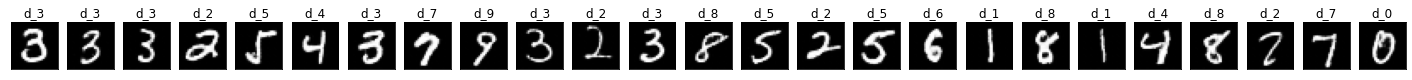

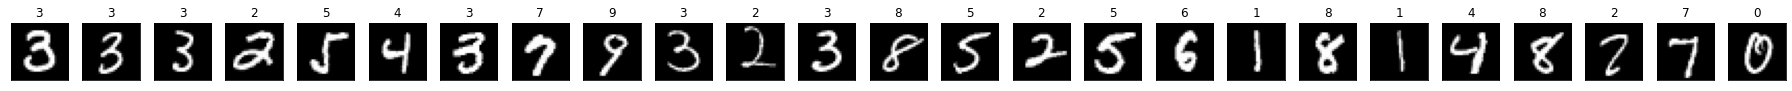

In [136]:
plot_images(model)